🎯 **TALLER 2: SERIES DE TIEMPO**

📅 **Fecha:** 2025

👤 **Equipo:** [Hector Hernan Betancourt Lopez - Marcela Fajardo Bermúdez]

* Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses empleando los métodos vistos en la clase. Compare
los resultados con el mejor modelo encontrado en el ejercicio anterior. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

# **1. Importación de librerias**

In [1]:
import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# **2. Carga de datos y vista rápida**

In [2]:
data = pd.read_excel("C:/Users/mafab/Documents/Fundamentos_Analitica/Series_de_tiempo/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head(3)

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120


# **3. Hold-out**

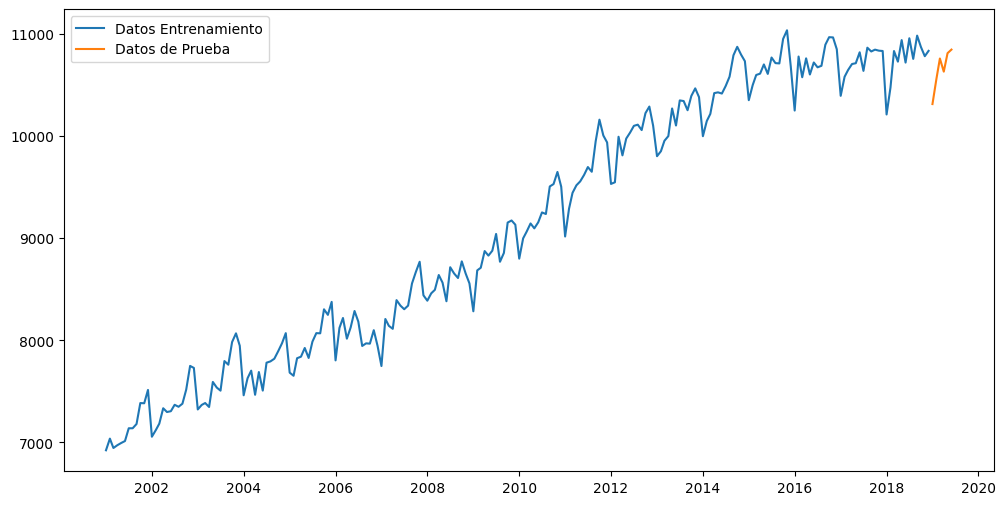

In [3]:
train_len = 216
h = 6
train_td = data[['Ocupados']][:train_len]
test_td = data[['Ocupados']][train_len:train_len+h]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

# **4. Construcción de modelos**

## **Modelo ejercicio 1**

In [4]:
# 1. El mejor modelo ETS del ejercicio anteior

ets_best_model = ETSModel(endog=train_td["Ocupados"], error="add", trend="mul", seasonal="mul", seasonal_periods=12)
ets_best_result = ets_best_model.fit()

point_forecast=ets_best_result.forecast(6)

ci = ets_best_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw = pd.concat([limits, conf_forecast], axis = 1)
preds_hw.columns = ['Point_forecast', 'lower_95', 'upper_95']
display(preds_hw)

c:\Users\mafab\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,Point_forecast,lower_95,upper_95
2019-01-01,10367.422831,10136.919951,10606.679370
2019-02-01,10585.328713,10327.093751,10835.520333
2019-03-01,10687.307289,10412.749998,10969.339079
2019-04-01,10715.020098,10421.327903,11040.538959
2019-05-01,10802.091088,10467.353908,11138.652143
2019-06-01,10775.733097,10423.098454,11145.411761


In [5]:
# Cálculo de métricas

rmse_hw = np.sqrt(((point_forecast - test_td['Ocupados']) ** 2).mean())
mae_hw = mean_absolute_error(test_td['Ocupados'], point_forecast)

print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse_hw}")
print(f"Error Absoluto Medio (MAE): {mae_hw}")

Raíz del Error Cuadrático Medio (RMSE): 59.4217184356385
Error Absoluto Medio (MAE): 53.33886114657495


## **Modelo tendencia Lineal**

In [6]:
# 2. Modelo con tendencia lineal

y = train_td['Ocupados']
x = np.linspace(1,train_td.shape[0],train_td.shape[0])
X = sm.add_constant(x)
lin = sm.OLS(y,X)
lin_t = lin.fit()
print(lin_t.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     5386.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):          1.10e-153
Time:                        21:12:02   Log-Likelihood:                -1500.2
No. Observations:                 216   AIC:                             3004.
Df Residuals:                     214   BIC:                             3011.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6925.6150     34.477    200.879      0.0

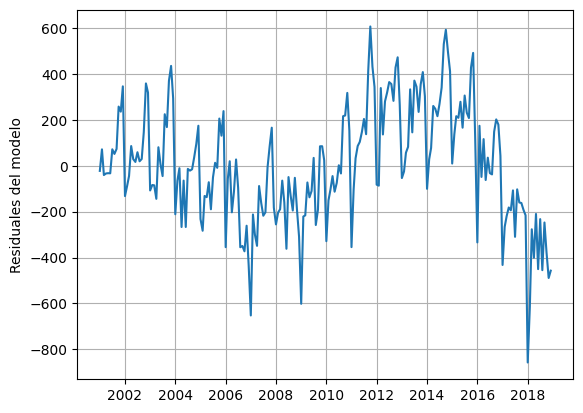

In [7]:
plt.ylabel("Residuales del modelo")
plt.plot(lin_t.resid)
plt.grid()
plt.show()

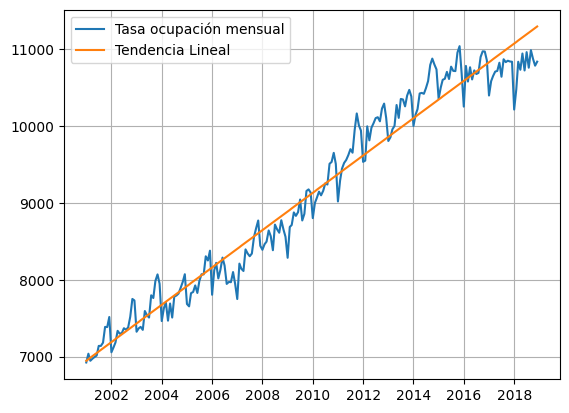

In [8]:
plt.plot(y,label="Tasa ocupación mensual")
plt.plot(lin_t.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [9]:
x_for= np.linspace((train_td.shape[0]+1),(train_td.shape[0]+h),h)
X_for= sm.add_constant(x_for)

In [10]:
dt = lin_t.get_prediction(X_for).summary_frame(alpha=0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

preds_lin = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]),
                     columns=['Point_forecast', 'lower_95', 'upper_95'], index=test_td.index)

display(preds_lin)

,Point_forecast,lower_95,upper_95
mes,,,
2019-01-01,11313.116341,10810.849071,11815.383612
2019-02-01,11333.335242,10831.003977,11835.666506
2019-03-01,11353.554142,10851.158304,11855.949979
2019-04-01,11373.773042,10871.312053,11876.234030
2019-05-01,11393.991942,10891.465223,11896.518660
2019-06-01,11414.210842,10911.617816,11916.803868


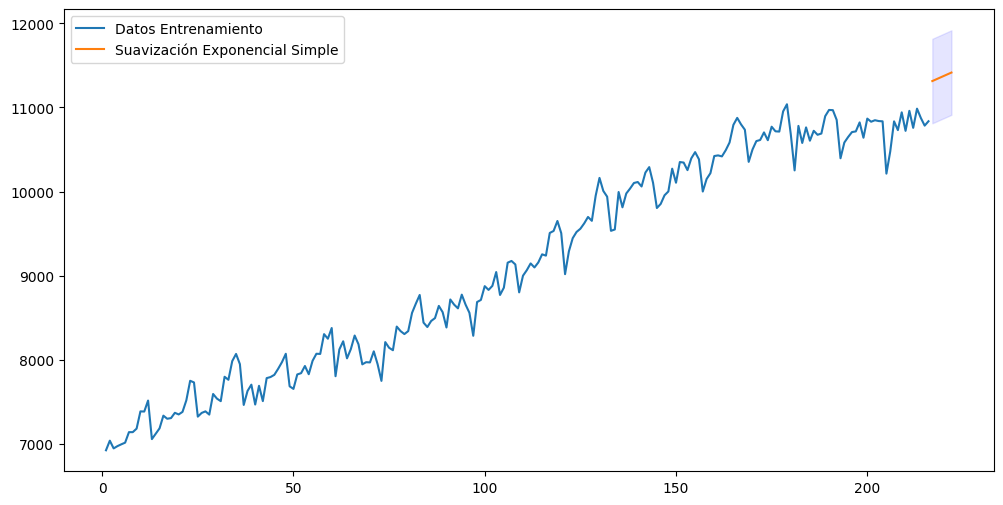

In [11]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x,y,label="Datos Entrenamiento")
plt.plot(x_for,preds_lin['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(x_for ,preds_lin['lower_95'], preds_lin['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [12]:
# Cálculo de métricas

rmse_lin = np.sqrt(((preds_lin['Point_forecast'] - test_td['Ocupados']) ** 2).mean())
mae_lin = mean_absolute_error(test_td['Ocupados'], preds_lin['Point_forecast'])

print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse_lin}")
print(f"Error Absoluto Medio (MAE): {mae_lin}")

Raíz del Error Cuadrático Medio (RMSE): 725.5285275153046
Error Absoluto Medio (MAE): 709.3037583910864


## **Modelo tendencia Cuadratica**

In [13]:
# 3. Modelo con tendencia cuadratica

y = train_td['Ocupados']
train_td["x"] = np.linspace(1,train_td.shape[0],train_td.shape[0])
train_td["x2"] = x**2
X = sm.add_constant(train_td[["x","x2"]])
pol = sm.OLS(y,X)
pol_2 = pol.fit()
print(pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     2752.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):          6.85e-153
Time:                        21:12:03   Log-Likelihood:                -1497.5
No. Observations:                 216   AIC:                             3001.
Df Residuals:                     213   BIC:                             3011.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6835.5053     51.482    132.774      0.0

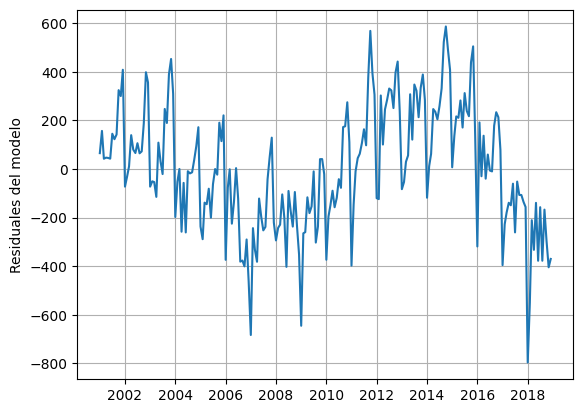

In [14]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_2.resid)
plt.grid()
plt.show()

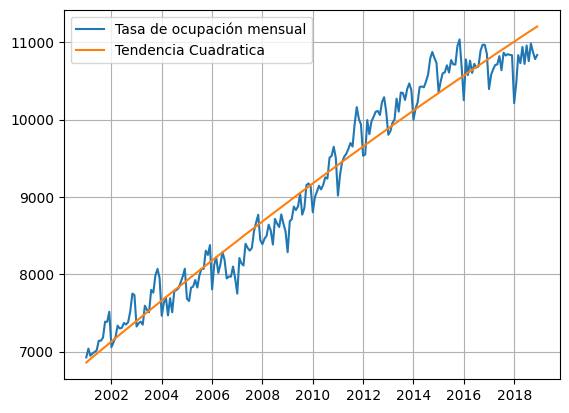

In [15]:
plt.plot(y,label="Tasa de ocupación mensual")
plt.plot(pol_2.fittedvalues,label="Tendencia Cuadratica")
plt.legend()
plt.grid()
plt.show()

In [16]:
x_for= np.linspace((train_td.shape[0]+1),(train_td.shape[0]+h),h)
X_for= sm.add_constant(np.stack((x_for, x_for**2), axis=1))

In [17]:
dt = pol_2.get_prediction(X_for).summary_frame(alpha=0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]),
                     columns=['Point_forecast', 'lower_95', 'upper_95'], index=test_td.index)

display(preds)

,Point_forecast,lower_95,upper_95
mes,,,
2019-01-01,11223.006575,10720.110033,11725.903118
2019-02-01,11240.733961,10737.453096,11744.014826
2019-03-01,11258.438489,10754.761188,11762.115790
2019-04-01,11276.120159,10772.034093,11780.206225
2019-05-01,11293.778971,10789.271596,11798.286346
2019-06-01,11311.414925,10806.473482,11816.356368


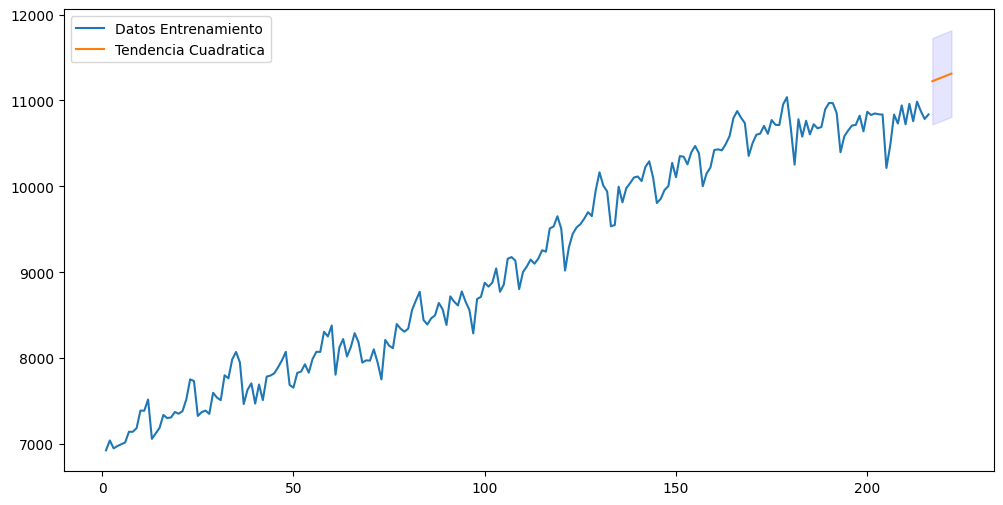

In [18]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x,y,label="Datos Entrenamiento")
plt.plot(x_for,preds['Point_forecast'],label="Tendencia Cuadratica")
plt.fill_between(x_for ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [19]:
# Cálculo de métricas

rmse_quad = np.sqrt(((preds['Point_forecast'] - test_td['Ocupados']) ** 2).mean())
mae_quad = mean_absolute_error(test_td['Ocupados'], preds['Point_forecast'])

print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse_quad}")
print(f"Error Absoluto Medio (MAE): {mae_quad}")

Raíz del Error Cuadrático Medio (RMSE): 632.4766573063225
Error Absoluto Medio (MAE): 612.8890133972233


## **Modelo tendencia Cubica**

In [20]:
# 3. Modelo con tendencia cubica

y = train_td['Ocupados']
train_td["x"] = np.linspace(1,train_td.shape[0],train_td.shape[0])
train_td["x2"] = x**2
train_td["x3"] = x**3
X = sm.add_constant(train_td[["x","x2", "x3"]])
cubi = sm.OLS(y,X)
cubi_2 = cubi.fit()
print(cubi_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     2949.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):          1.62e-172
Time:                        21:12:04   Log-Likelihood:                -1447.3
No. Observations:                 216   AIC:                             2903.
Df Residuals:                     212   BIC:                             2916.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7247.0943     54.981    131.810      0.0

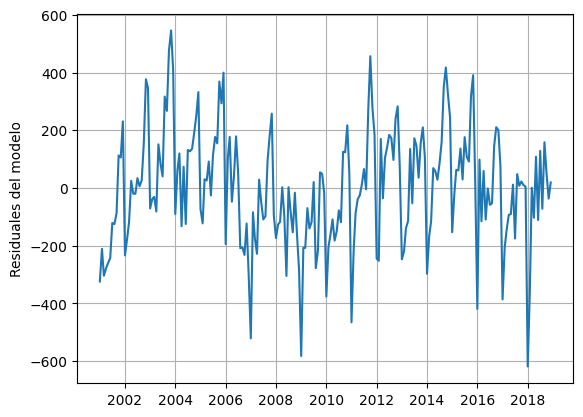

In [21]:
plt.ylabel("Residuales del modelo")
plt.plot(cubi_2.resid)
plt.grid()
plt.show()

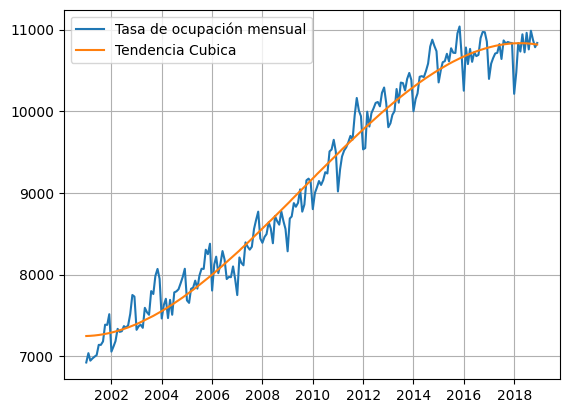

In [22]:
plt.plot(y,label="Tasa de ocupación mensual")
plt.plot(cubi_2.fittedvalues,label="Tendencia Cubica")
plt.legend()
plt.grid()
plt.show()

In [23]:
x_for= np.linspace((train_td.shape[0]+1),(train_td.shape[0]+h),h)
X_for= sm.add_constant(np.stack((x_for, x_for**2, x_for**3), axis=1))

In [24]:
dt = cubi_2.get_prediction(X_for).summary_frame(alpha=0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

preds_cu = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]),
                     columns=['Point_forecast', 'lower_95', 'upper_95'], index=test_td.index)

display(preds_cu)

,Point_forecast,lower_95,upper_95
mes,,,
2019-01-01,10811.417558,10405.366847,11217.468269
2019-02-01,10806.384261,10399.300099,11213.468422
2019-03-01,10800.806072,10392.623990,11208.988153
2019-04-01,10794.678223,10385.331151,11204.025296
2019-05-01,10787.995948,10377.414173,11198.577723
2019-06-01,10780.754478,10368.865618,11192.643339


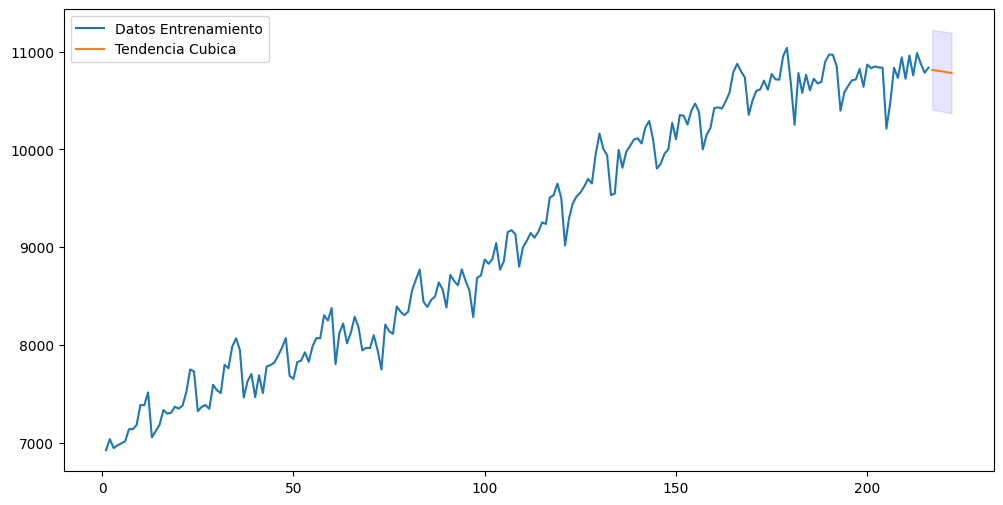

In [25]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x,y,label="Datos Entrenamiento")
plt.plot(x_for,preds_cu['Point_forecast'],label="Tendencia Cubica")
plt.fill_between(x_for ,preds_cu['lower_95'], preds_cu['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [26]:
# Cálculo de métricas

rmse_cu = np.sqrt(((preds_cu['Point_forecast'] - test_td['Ocupados']) ** 2).mean())
mae_cu = mean_absolute_error(test_td['Ocupados'], preds_cu['Point_forecast'])

print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse_cu}")
print(f"Error Absoluto Medio (MAE): {mae_cu}")

Raíz del Error Cuadrático Medio (RMSE): 238.7220577446053
Error Absoluto Medio (MAE): 173.3961145273979


## **Modelo tendencia con varios grados**

In [27]:
metrics_data = []

# Iterar a través de los grados polinómicos del 4 al 10
for degree in range(4, 11):

    x = np.linspace(1, train_td.shape[0], train_td.shape[0])
    X = np.column_stack([x**i for i in range(1, degree + 1)])
    # Añadir una constante (intercepto)
    X = sm.add_constant(X)
    # Ajustar el modelo OLS
    pol_model = sm.OLS(train_td["Ocupados"], X).fit()

    # Datos de prueba
    x_test = np.linspace(train_td.shape[0] + 1, train_td.shape[0] + test_td.shape[0], test_td.shape[0])
    X_test = np.column_stack([x_test**i for i in range(1, degree + 1)])
    X_test = sm.add_constant(X_test)
    # Predicción
    test_predictions = pol_model.predict(X_test)

    # Calcular RMSE
    rmse = np.sqrt(((test_predictions - test_td['Ocupados']) ** 2).mean())

    # Calcular MAE
    mae = mean_absolute_error(test_td['Ocupados'], test_predictions)

    # Almacenar ambos RMSE y MAE
    metrics_data.append({'Polynomial Degree': degree, 'RMSE': rmse, 'MAE': mae})

# Crear DataFrame a partir de los resultados y ordenar por RMSE
poly_metrics_df = pd.DataFrame(metrics_data)
poly_metrics_df_sorted = poly_metrics_df.sort_values(by='RMSE').reset_index(drop=True)
display(poly_metrics_df_sorted)

# Mejor grado polinómico
best_row = poly_metrics_df_sorted.iloc[0]
print(f"\nEl grado polinómico con menor RMSE es: {int(best_row['Polynomial Degree'])} (RMSE: {best_row['RMSE']:.2f}, MAE: {best_row['MAE']:.2f})")

,Polynomial Degree,RMSE,MAE
0,5,227.121457,159.962524
1,4,269.904246,233.911773
2,6,320.001174,284.310132
3,7,3748.530494,3488.361660
4,8,6126.239028,5651.985393
5,9,8725.849035,7957.315738
6,10,13206.763487,12241.697030



El grado polinómico con menor RMSE es: 5 (RMSE: 227.12, MAE: 159.96)


## **Modelo con estimación de la Estacionalidad**

In [28]:
month_dummies = pd.get_dummies(train_td.index.month, drop_first=True).set_index(train_td.index)
dummy_columns = month_dummies.columns

y = train_td['Ocupados']
X = sm.add_constant(month_dummies.astype(int))

sea = sm.OLS(y, X)
season = sea.fit()

print(season.summary())


                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.3897
Date:                Wed, 05 Nov 2025   Prob (F-statistic):              0.959
Time:                        21:12:04   Log-Likelihood:                -1850.6
No. Observations:                 216   AIC:                             3725.
Df Residuals:                     204   BIC:                             3766.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8724.5387    308.558     28.275      0.0

In [29]:
month_dummies

,2,3,4,5,6,7,8,9,10,11,12
mes,,,,,,,,,,,
2001-01-01,False,False,False,False,False,False,False,False,False,False,False
2001-02-01,True,False,False,False,False,False,False,False,False,False,False
2001-03-01,False,True,False,False,False,False,False,False,False,False,False
2001-04-01,False,False,True,False,False,False,False,False,False,False,False
2001-05-01,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,False,False,False,False,False,False,True,False,False,False,False
2018-09-01,False,False,False,False,False,False,False,True,False,False,False
2018-10-01,False,False,False,False,False,False,False,False,True,False,False


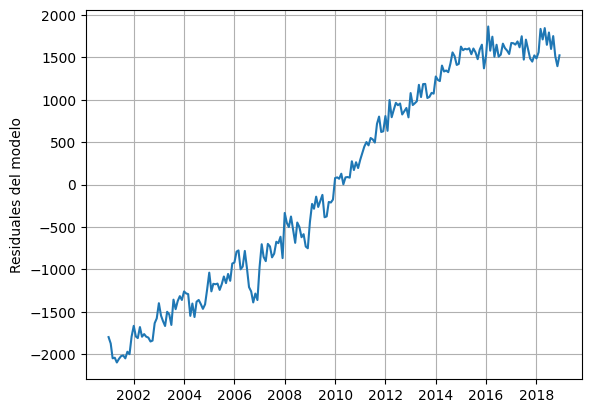

In [30]:
plt.ylabel("Residuales del modelo")
plt.plot(season.resid)
plt.grid()
plt.show()

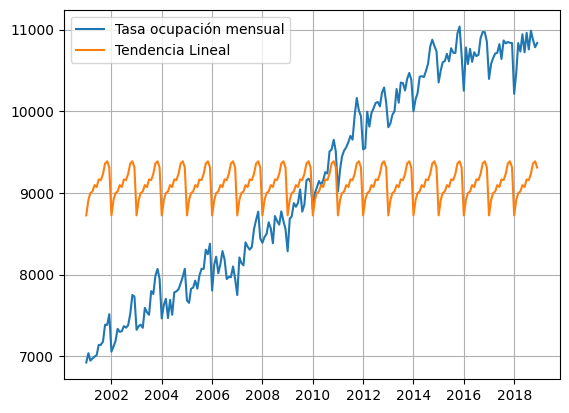

In [31]:
plt.plot(y,label="Tasa ocupación mensual")
plt.plot(season.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [32]:
range_dates = pd.date_range(train_td.index[-1] + relativedelta(months=1), periods=h, freq='MS')

# Crear dummies para fechas futuras
x_for = pd.get_dummies(range_dates.month, drop_first=True)

# Reindexar para que coincida con las columnas de entrenamiento
x_for = x_for.reindex(columns=dummy_columns, fill_value=0) #ESTA ES LA QUE DEBO MODIFICAR PARA EVITAR ERRORES DE DIMENSIONALIDAD Y ALINEACIÓN.

# Agregar constante
X_for = sm.add_constant(x_for)


In [33]:
dt = season.get_prediction(X_for.astype(int)).summary_frame(alpha = 0.05)

y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']

preds_sea = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds_sea.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds_sea.set_index(range_dates,inplace=True)
display(preds_sea)

,Point_forecast,lower_95,upper_95
2019-01-01,8724.538722,6072.708767,11376.368678
2019-02-01,8914.544389,6262.714433,11566.374344
2019-03-01,8997.218333,6345.388378,11649.048289
2019-04-01,9017.681722,6365.851767,11669.511678
2019-05-01,9095.089000,6443.259045,11746.918955
2019-06-01,9071.789000,6419.959045,11723.618955


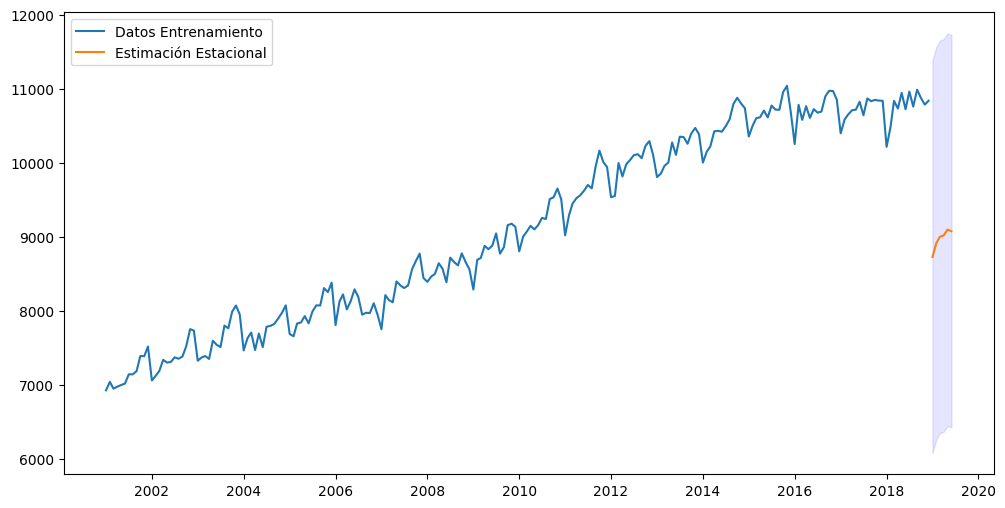

In [34]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds_sea.index,preds_sea['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds_sea.index,preds_sea['lower_95'], preds_sea['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [35]:
# Cálculo de métricas

rmse_sea = np.sqrt(((preds_sea['Point_forecast'] - test_td['Ocupados']) ** 2).mean())
mae_sea = mean_absolute_error(test_td['Ocupados'], preds_sea['Point_forecast'])

print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse_sea}")
print(f"Error Absoluto Medio (MAE): {mae_sea}")

Raíz del Error Cuadrático Medio (RMSE): 1685.76622149021
Error Absoluto Medio (MAE): 1684.2163055555595


## **Modelo con tendencia cuadratica + estacionalidad**

In [ ]:
y = train_td['Ocupados']
train_td["x"] = np.linspace(1,train_td.shape[0],train_td.shape[0])
train_td["x2"] = x**2

month_dummies = pd.get_dummies(train_td.index.month,drop_first=True).set_index(train_td.index)

X = sm.add_constant( pd.concat([train_td[["x","x2"]],month_dummies.astype(int)],axis=1) )

season_pol2 = sm.OLS(y,X)
season_pol_2 = season_pol2.fit()
print(season_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     528.1
Date:                Wed, 05 Nov 2025   Prob (F-statistic):          4.37e-148
Time:                        21:12:05   Log-Likelihood:                -1468.9
No. Observations:                 216   AIC:                             2966.
Df Residuals:                     202   BIC:                             3013.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6562.0204     68.138     96.304      0.0

In [37]:
X

,const,x,x2,2,3,4,5,6,7,8,9,10,11,12
mes,,,,,,,,,,,,,,
2001-01-01,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0
2001-02-01,1.0,2.0,4.0,1,0,0,0,0,0,0,0,0,0,0
2001-03-01,1.0,3.0,9.0,0,1,0,0,0,0,0,0,0,0,0
2001-04-01,1.0,4.0,16.0,0,0,1,0,0,0,0,0,0,0,0
2001-05-01,1.0,5.0,25.0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,1.0,212.0,44944.0,0,0,0,0,0,0,1,0,0,0,0
2018-09-01,1.0,213.0,45369.0,0,0,0,0,0,0,0,1,0,0,0
2018-10-01,1.0,214.0,45796.0,0,0,0,0,0,0,0,0,1,0,0


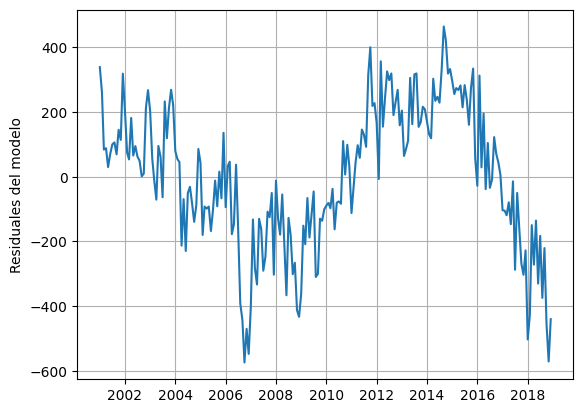

In [38]:
plt.ylabel("Residuales del modelo")
plt.plot(season_pol_2.resid)
plt.grid()
plt.show()

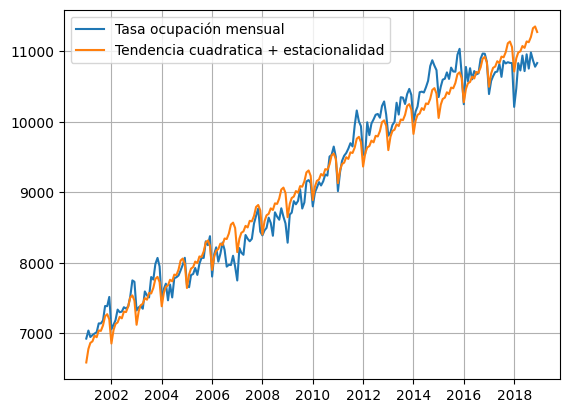

In [39]:
plt.plot(y,label="Tasa ocupación mensual")
plt.plot(season_pol_2.fittedvalues,label="Tendencia cuadratica + estacionalidad")
plt.legend()
plt.grid()
plt.show()

In [40]:
# 1. Tendencia cuadrática para próximas h observaciones
x_for = np.linspace((train_td.shape[0]+1),(train_td.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2), axis=1), columns=["x","x2"])

# 2. Variables dummy para meses futuros
range_dates = pd.date_range(train_td.index[-1] + relativedelta(months=1), periods=h, freq='MS')
x_for_dummies = pd.get_dummies(range_dates.month, drop_first=True)

# 3. Reindexar columnas dummy según entrenamiento para evitar errores de dimensión
x_for_dummies = x_for_dummies.reindex(columns=dummy_columns, fill_value=0)

# 4. Concatenar todas variables predictoras y añadir constante
X_for = sm.add_constant(pd.concat([x_for_all, x_for_dummies], axis=1))
X_for

,const,x,x2,2,3,4,5,6,7,8,9,10,11,12
0,1.0,217.0,47089.0,False,False,False,False,False,0,0,0,0,0,0
1,1.0,218.0,47524.0,True,False,False,False,False,0,0,0,0,0,0
2,1.0,219.0,47961.0,False,True,False,False,False,0,0,0,0,0,0
3,1.0,220.0,48400.0,False,False,True,False,False,0,0,0,0,0,0
4,1.0,221.0,48841.0,False,False,False,True,False,0,0,0,0,0,0
5,1.0,222.0,49284.0,False,False,False,False,True,0,0,0,0,0,0


In [41]:
dt = season_pol_2.get_prediction(X_for.astype(int)).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds_pol_sea = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds_pol_sea.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds_pol_sea.set_index(range_dates,inplace=True)
display(preds_pol_sea)

,Point_forecast,lower_95,upper_95
2019-01-01,10928.984636,10465.310322,11392.658951
2019-02-01,11116.389734,10652.420472,11580.358996
2019-03-01,11196.463110,10732.190668,11660.735551
2019-04-01,11214.325929,10749.742094,11678.909765
2019-05-01,11289.132638,10824.229209,11754.036068
2019-06-01,11263.232069,10798.000864,11728.463274


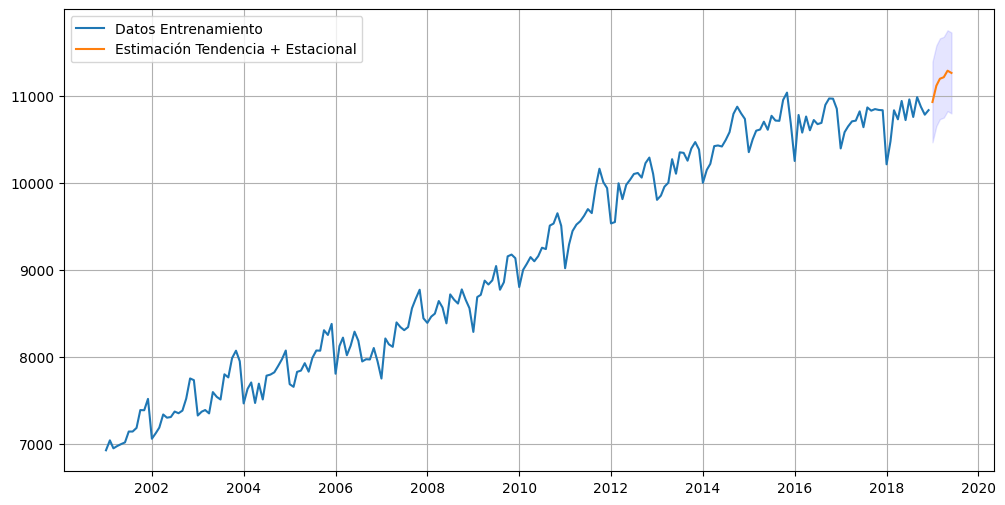

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(train_td.index, y, label="Datos Entrenamiento")
plt.plot(preds_pol_sea.index, preds_pol_sea['Point_forecast'], label="Estimación Tendencia + Estacional")
plt.fill_between(preds_pol_sea.index, preds_pol_sea['lower_95'], preds_pol_sea['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [43]:
# Cálculo de métricas

rmse_pol_sea = np.sqrt(((preds_pol_sea['Point_forecast'] - test_td['Ocupados']) ** 2).mean())
mae_pol_sea = mean_absolute_error(test_td['Ocupados'], preds_pol_sea['Point_forecast'])

print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse_pol_sea}")
print(f"Error Absoluto Medio (MAE): {mae_pol_sea}")

Raíz del Error Cuadrático Medio (RMSE): 519.225939837616
Error Absoluto Medio (MAE): 513.728186154624


## **Modelo con tendencia cubica + estacionalidad**

In [44]:
y = train_td['Ocupados']
train_td["x"] = np.linspace(1,train_td.shape[0],train_td.shape[0])
train_td["x2"] = x**2
train_td["x3"] = x**3
# train_td["x2"] = train_td["x"] ** 2

month_dummies = pd.get_dummies(train_td.index.month,drop_first=True).set_index(train_td.index)

X = sm.add_constant( pd.concat([train_td[["x","x2", "x3"]],month_dummies.astype(int)],axis=1) )

season_cu3 = sm.OLS(y,X)
season_cu_3 = season_cu3.fit()
print(season_cu_3.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     1096.
Date:                Wed, 05 Nov 2025   Prob (F-statistic):          2.56e-181
Time:                        21:12:06   Log-Likelihood:                -1383.2
No. Observations:                 216   AIC:                             2796.
Df Residuals:                     201   BIC:                             2847.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6980.7137     53.194    131.232      0.0

In [45]:
X

,const,x,x2,x3,2,3,4,5,6,7,8,9,10,11,12
mes,,,,,,,,,,,,,,,
2001-01-01,1.0,1.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0
2001-02-01,1.0,2.0,4.0,8.0,1,0,0,0,0,0,0,0,0,0,0
2001-03-01,1.0,3.0,9.0,27.0,0,1,0,0,0,0,0,0,0,0,0
2001-04-01,1.0,4.0,16.0,64.0,0,0,1,0,0,0,0,0,0,0,0
2001-05-01,1.0,5.0,25.0,125.0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-01,1.0,212.0,44944.0,9528128.0,0,0,0,0,0,0,1,0,0,0,0
2018-09-01,1.0,213.0,45369.0,9663597.0,0,0,0,0,0,0,0,1,0,0,0
2018-10-01,1.0,214.0,45796.0,9800344.0,0,0,0,0,0,0,0,0,1,0,0


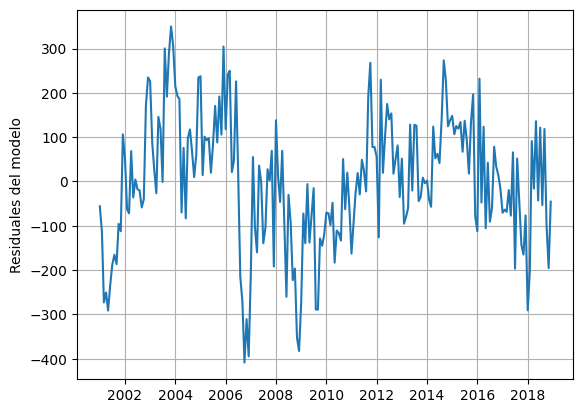

In [46]:
plt.ylabel("Residuales del modelo")
plt.plot(season_cu_3.resid)
plt.grid()
plt.show()

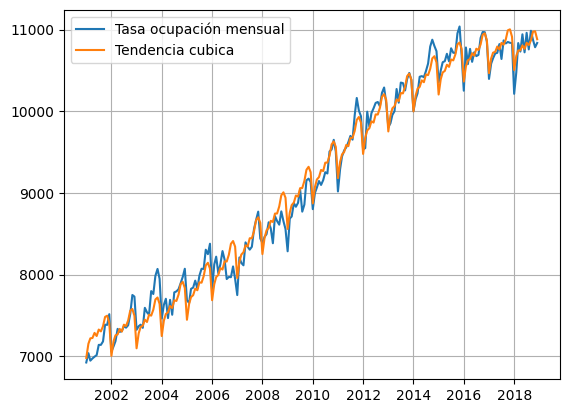

In [47]:
plt.plot(y,label="Tasa ocupación mensual")
plt.plot(season_cu_3.fittedvalues,label="Tendencia cubica")
plt.legend()
plt.grid()
plt.show()

In [48]:
# 1. Tendencia cuadrática para próximas h observaciones
x_for = np.linspace((train_td.shape[0]+1),(train_td.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2, x_for**3), axis=1), columns=["x","x2", "x3"])

# 2. Variables dummy para meses futuros
range_dates = pd.date_range(train_td.index[-1] + relativedelta(months=1), periods=h, freq='MS')
x_for_dummies = pd.get_dummies(range_dates.month, drop_first=True)

# 3. Reindexar columnas dummy según entrenamiento para evitar errores de dimensión
x_for_dummies = x_for_dummies.reindex(columns=dummy_columns, fill_value=0)

# 4. Concatenar todas variables predictoras y añadir constante
X_for = sm.add_constant(pd.concat([x_for_all, x_for_dummies], axis=1))
X_for

,const,x,x2,x3,2,3,4,5,6,7,8,9,10,11,12
0,1.0,217.0,47089.0,10218313.0,False,False,False,False,False,0,0,0,0,0,0
1,1.0,218.0,47524.0,10360232.0,True,False,False,False,False,0,0,0,0,0,0
2,1.0,219.0,47961.0,10503459.0,False,True,False,False,False,0,0,0,0,0,0
3,1.0,220.0,48400.0,10648000.0,False,False,True,False,False,0,0,0,0,0,0
4,1.0,221.0,48841.0,10793861.0,False,False,False,True,False,0,0,0,0,0,0
5,1.0,222.0,49284.0,10941048.0,False,False,False,False,True,0,0,0,0,0,0


In [49]:
dt = season_cu_3.get_prediction(X_for.astype(int)).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds_cu_sea = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds_cu_sea.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds_cu_sea.set_index(range_dates,inplace=True)
display(preds_cu_sea)

,Point_forecast,lower_95,upper_95
2019-01-01,10466.696418,10148.714218,10784.678619
2019-02-01,10633.804521,10315.146080,10952.462963
2019-03-01,10693.000988,10373.626992,11012.374984
2019-04-01,10689.406985,10369.276573,11009.537396
2019-05-01,10742.176956,10421.247700,11063.106212
2019-06-01,10693.659736,10371.887620,11015.431852


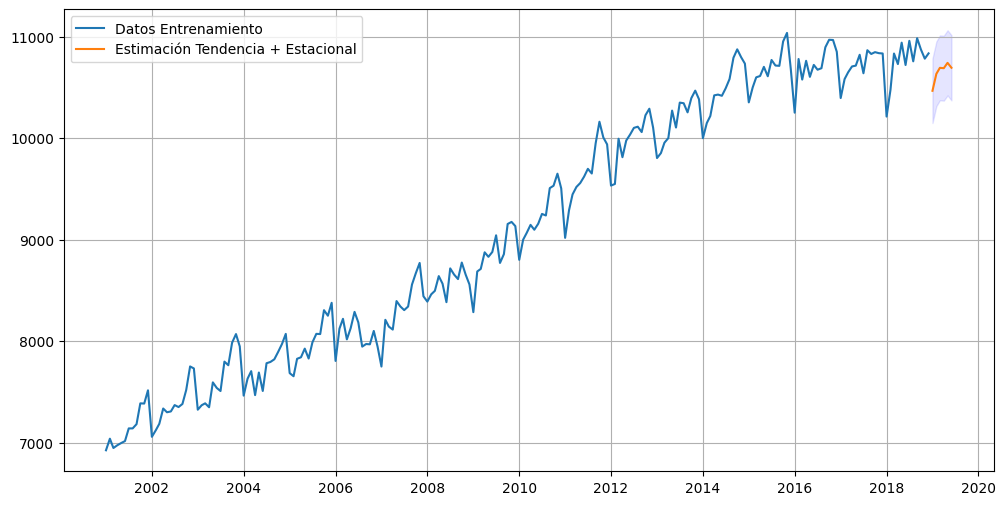

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(train_td.index, y, label="Datos Entrenamiento")
plt.plot(preds_cu_sea.index, preds_cu_sea['Point_forecast'], label="Estimación Tendencia + Estacional")
plt.fill_between(preds_cu_sea.index, preds_cu_sea['lower_95'], preds_cu_sea['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [51]:
# Cálculo de métricas

rmse_cu_sea = np.sqrt(((preds_cu_sea['Point_forecast'] - test_td['Ocupados']) ** 2).mean())
mae_cu_sea = mean_absolute_error(test_td['Ocupados'], preds_cu_sea['Point_forecast'])

print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse_cu_sea}")
print(f"Error Absoluto Medio (MAE): {mae_cu_sea}")

Raíz del Error Cuadrático Medio (RMSE): 104.61370412859476
Error Absoluto Medio (MAE): 96.41054065764638


## **Modelo tendencias con varios grados + estacionalidad**

In [52]:
rmse_values = {}
mae_values = {}

# Guardar columnas dummy de meses para mantener consistencia en prueba
dummy_columns = pd.get_dummies(train_td.index.month, drop_first=True).columns

for degree in range(4, 11):
    # Crear variable x para tendencia (1, 2, ..., n)
    x = np.linspace(1, train_td.shape[0], train_td.shape[0])

    # Crear matriz de características polinómicas hasta grado 'degree'
    poly_features = np.column_stack([x**i for i in range(1, degree + 1)])
    poly_df = pd.DataFrame(poly_features,
                           columns=[f'x{i}' for i in range(1, degree + 1)],
                           index=train_td.index)

    # Variables dummy para estacionalidad (meses)
    month_dummies = pd.get_dummies(train_td.index.month, drop_first=True).set_index(train_td.index)

    # Concatenar tendencia polinómica y estacionalidad
    X_train = pd.concat([poly_df, month_dummies.astype(int)], axis=1)
    X_train = sm.add_constant(X_train)  # Añadir constante para intercepto

    # Ajustar modelo OLS
    model = sm.OLS(train_td['Ocupados'], X_train)
    results = model.fit()

    # Preparar datos de prueba: generar polinomios
    x_test = np.linspace(train_td.shape[0] + 1, train_td.shape[0] + test_td.shape[0], test_td.shape[0])
    poly_features_test = np.column_stack([x_test**i for i in range(1, degree + 1)])
    poly_df_test = pd.DataFrame(poly_features_test,
                               columns=[f'x{i}' for i in range(1, degree + 1)],
                               index=test_td.index)

    # Variables dummy para estacionalidad en test
    month_dummies_test = pd.get_dummies(test_td.index.month, drop_first=True).set_index(test_td.index)
    # Reindexar para que coincidan las columnas con entrenamiento
    month_dummies_test = month_dummies_test.reindex(columns=dummy_columns, fill_value=0)

    # Concatenar polinomios y dummies
    X_test = pd.concat([poly_df_test, month_dummies_test.astype(int)], axis=1)
    X_test = sm.add_constant(X_test)  # Añadir constante

    # Predicciones
    predictions = results.predict(X_test)

    # Calcular RMSE y MAE
    rmse = sqrt(mean_squared_error(test_td['Ocupados'], predictions))
    mae = mean_absolute_error(test_td['Ocupados'], predictions)

    rmse_values[degree] = rmse
    mae_values[degree] = mae

# Crear DataFrame con RMSE y MAE ordenados por RMSE
rmse_df = pd.DataFrame({
    'Polynomial Degree': list(rmse_values.keys()),
    'RMSE': list(rmse_values.values()),
    'MAE': [mae_values[d] for d in rmse_values.keys()]
}).sort_values('RMSE').reset_index(drop=True)

print("RMSE y MAE para cada grado polinómico con estacionalidad incluida:")
display(rmse_df)

# Mejor grado
best_degree = min(rmse_values, key=rmse_values.get)
print(f"\nEl grado polinómico con menor RMSE es: {best_degree} (RMSE: {rmse_values[best_degree]:.2f})")

RMSE y MAE para cada grado polinómico con estacionalidad incluida:


,Polynomial Degree,RMSE,MAE
0,6,114.184788,88.484172
1,5,115.951705,95.179943
2,4,320.653029,288.056052
3,7,3749.302455,3489.093298
4,8,6126.328218,5652.079282
5,9,8737.563668,7972.314846
6,10,13206.763355,12241.696917



El grado polinómico con menor RMSE es: 6 (RMSE: 114.18)


# **5. Comparación de modelos**

Para realizar la comparación de los modelos se debe usar una metrica de desempeño, en la clase anterior usamos el RMSE, la comparación se debe hacer fuera de muestra.

In [53]:
Resultados_RMSE = {
    'Holt-Winter (error=add,trend=mul,seasonal=mul)': rmse_hw,
    'Tendencia Lineal': rmse_lin,
    'Tendencia Cuadrática': rmse_quad,
    'Tendencia Cubica': rmse_cu,
    'Estacional': rmse_sea,
    'Tendencia Cuadrática + Estacional': rmse_pol_sea,
    'Tendencia Cubica + Estacional': rmse_cu_sea,
}

Resultados_MAE = {
    'Holt-Winter (error=add,trend=mul,seasonal=mul)': mae_hw,
    'Tendencia Lineal': mae_lin,
    'Tendencia Cuadrática': mae_quad,
    'Tendencia Cubica': mae_cu,
    'Estacional': mae_sea,
    'Tendencia Cuadrática + Estacional': mae_pol_sea,
    'Tendencia Cubica + Estacional': mae_cu_sea,
}

# Add results from polynomial models without seasonality
for _, row in poly_metrics_df_sorted.iterrows():
    Resultados_RMSE[f"Polinomial Grado {int(row['Polynomial Degree'])}"] = row['RMSE']
    Resultados_MAE[f"Polinomial Grado {int(row['Polynomial Degree'])}"] = row['MAE']

# Add results from polynomial models with seasonality
for _, row in rmse_df.iterrows():
    Resultados_RMSE[f"Polinomial Grado {int(row['Polynomial Degree'])} + Estacional"] = row['RMSE']
    Resultados_MAE[f"Polinomial Grado {int(row['Polynomial Degree'])} + Estacional"] = row['MAE']

# Crear DataFrames a partir de los diccionarios
df_rmse = pd.DataFrame.from_dict(Resultados_RMSE, orient='index', columns=['RMSE'])
df_mae = pd.DataFrame.from_dict(Resultados_MAE, orient='index', columns=['MAE'])

# Unir ambos DataFrames por índice (modelo)
df_metrics = df_rmse.join(df_mae)

# Agregar columna 'Modelo' con los índices
df_metrics.insert(0, 'Modelo', df_metrics.index)

# Ordenar por RMSE ascendente
df_metrics_sorted_rmse = df_metrics.sort_values(by='RMSE').reset_index(drop=True)

print("\nTabla comparativa de métricas por modelo (ordenada por RMSE):")
display(df_metrics_sorted_rmse)


Tabla comparativa de métricas por modelo (ordenada por RMSE):


,Modelo,RMSE,MAE
0,"Holt-Winter (error=add,trend=mul,seasonal=mul)",59.421718,53.338861
1,Tendencia Cubica + Estacional,104.613704,96.410541
2,Polinomial Grado 6 + Estacional,114.184788,88.484172
3,Polinomial Grado 5 + Estacional,115.951705,95.179943
4,Polinomial Grado 5,227.121457,159.962524
5,Tendencia Cubica,238.722058,173.396115
6,Polinomial Grado 4,269.904246,233.911773
7,Polinomial Grado 6,320.001174,284.310132
8,Polinomial Grado 4 + Estacional,320.653029,288.056052
9,Tendencia Cuadrática + Estacional,519.225940,513.728186


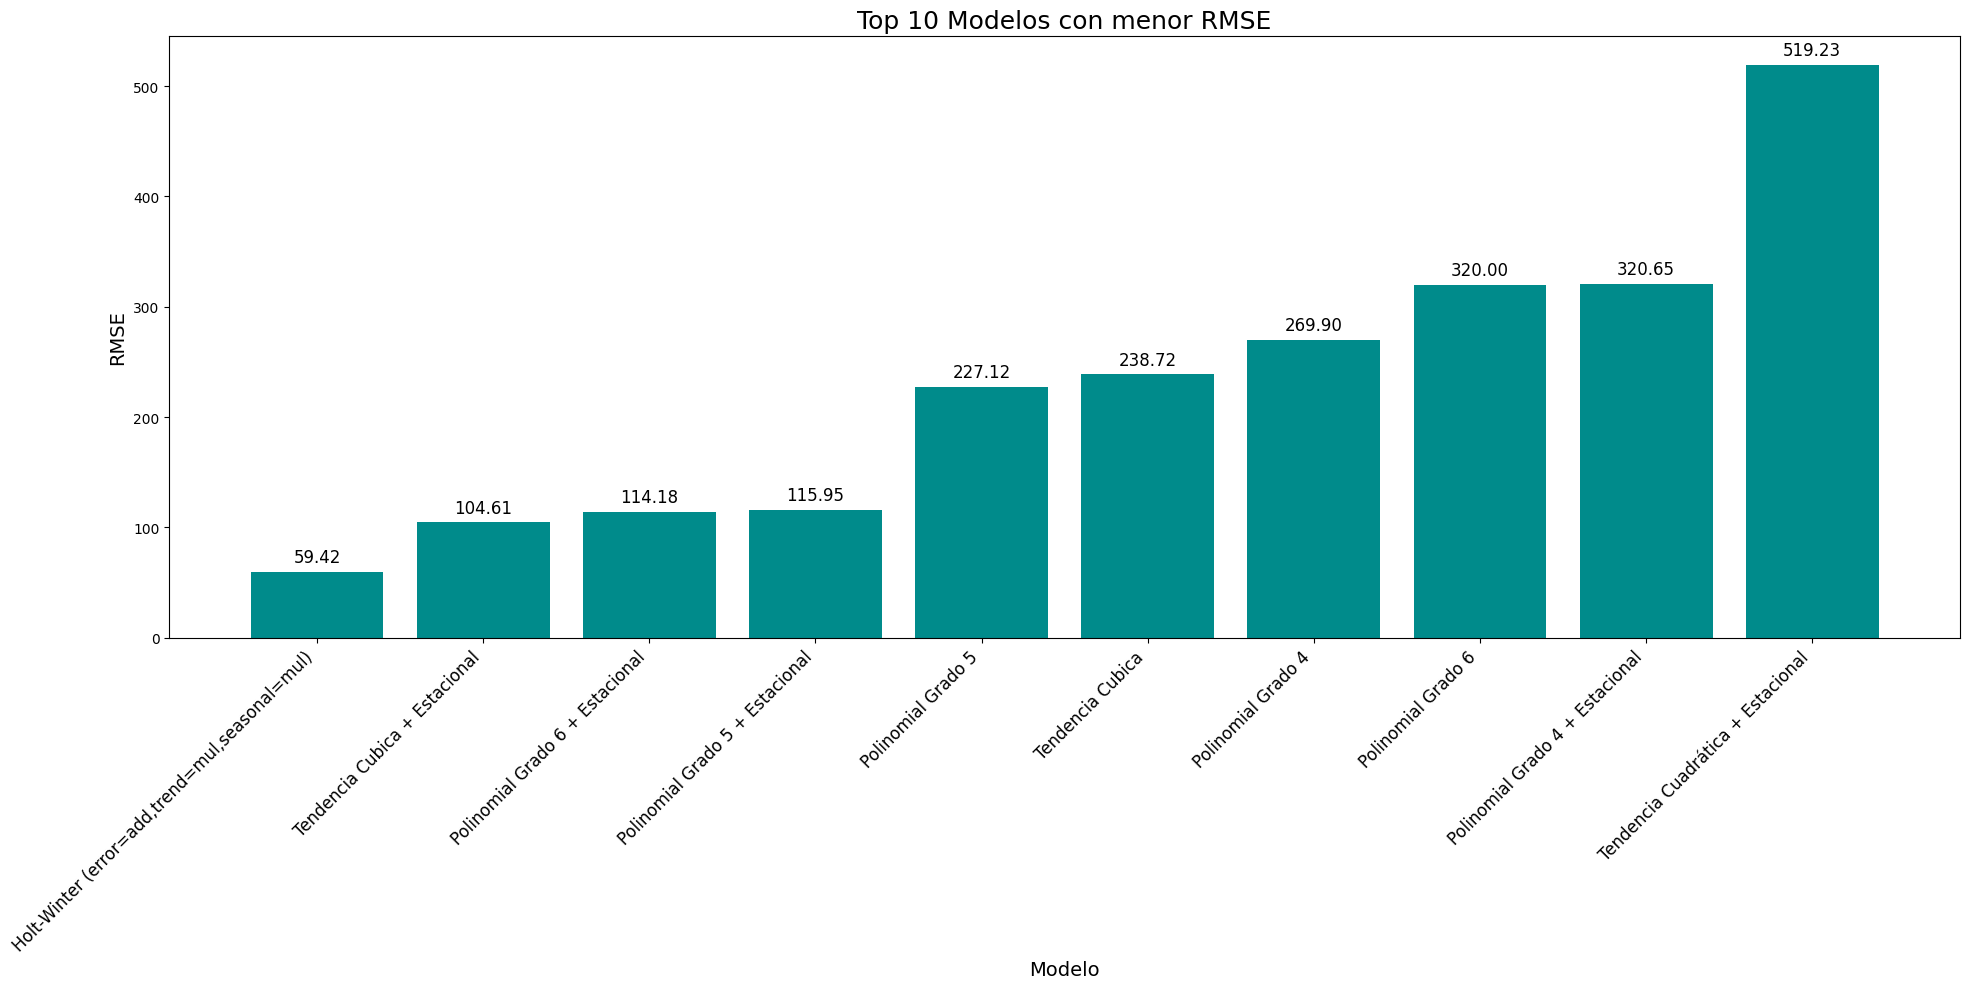

In [54]:
top_10 = df_metrics_sorted_rmse.head(10)

plt.figure(figsize=(20, 10))
bars = plt.bar(top_10['Modelo'], top_10['RMSE'], color='darkcyan')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.xlabel("Modelo", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.title("Top 10 Modelos con menor RMSE", fontsize=18)

# Etiquetar con valores RMSE encima de cada barra
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + (max(top_10['RMSE']) * 0.01),
        f'{yval:.2f}',
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.tight_layout()
plt.show()

**Nota:**

En los valores de las métricas de RMSE y MAE obtenidos para cada modelo, se observa que el modelo ETS presenta el mejor desempeño, con los valores más bajos de RMSE (59.42) y MAE (53.34), lo cual indica una mejor capacidad de generalización.

Por otra parte, uno de los modelos más complejos y el segundo mejor en RMSE es el de "Tendencia Cubica + Estacionalidad" ofrecen mayor precisión, por lo que, se resalta la importancia de combinar diferentes componentes para capturar tanto la evolución de la tendencia como el patron estacional de la serie de tiempo.

* **Raíz del Error Cuadrático Medio (RMSE - Root Mean Squared Error)**:
  Es la raíz cuadrada del MSE.Nos dice, en promedio, qué tan lejos están nuestras predicciones del valor real.


* **Error Absoluto Medio (MAE - Mean Absolute Error)**:

  Es el promedio de las diferencias absolutas entre los valores reales y los predichos. Similar al RMSE, pero es menos sensible a los valores atípicos (outliers) ya que no eleva los errores al cuadrado.

# **6. Validación de supuestos all data**

### **Autocorrelación**

Prueba no paramétrica donde las hipótesis son las siguientes:

$H{0}: ρ = 0$ (Es decir no hay autocorrelación)

$H{1}: ρ \not= 0$ (Es decir hay autocorrelación)

Rechazo $H{0}$ cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un $α$=0.05 ($α$ = nivel de significancia).

In [55]:
signo = data["Ocupados"] > data["Ocupados"].mean()

In [56]:
runstest_1samp(signo, correction=False)

(np.float64(-14.260364883750725), np.float64(3.864287094208414e-46))

**Nota:**

El segundo valor corresponde al p-valor, por lo tanto considerando un $α$=0.05, los resultados obtenidos no permiten rechazar la hipótesis nula, es decir, la serie Ocupados sí presenta autocorrelación

In [57]:
# prueba de Box-Pierce y la modificación de Ljung-Box
sm.stats.acorr_ljungbox(data['Ocupados'], lags=[1], return_df=True,boxpierce=True ) # Se puede hacer para un solo lag.

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,215.466151,8.818153e-49,212.580444,3.757527e-48


Con el resultado anterior rechazamos la hipótesis nula de no autocorrelación para el primer rezago, lo ideal antes de tomar la decisión
Es probar por lo menos los primeros 20 rezagos.

In [58]:
Resul_lb_bp = sm.stats.acorr_ljungbox(data['Ocupados'], lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,215.466151,8.818153e-49,212.580444,3.757527e-48,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,425.045838,5.040446e-93,418.417636,1.386005e-91,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,629.973395,3.201138e-136,618.770917,8.590288e-134,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,830.534686,1.866623e-178,813.960031,7.268819e-175,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,1028.006530,5.191558e-220,1005.260880,4.364213e-215,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,1222.035167,8.145806e-261,1192.359923,2.155332e-254,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,1412.841689,6.426069e-301,1375.500111,7.718370e-293,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,1599.512253,0.000000e+00,1553.837168,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,1782.749605,0.000000e+00,1728.076257,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,1963.258217,0.000000e+00,1898.914764,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


**Nota:**

En el anterior data frame las columnas lb_ho y bp_ho nos permiten entender la decisión a tomar al usar las dos pruebas, a pesar de analizar múltiples rezagos, la evidencia estadística (p-valores) indica que en todos los casos se rechaza la hipótesis nula de no autocorrelación. Por lo tanto, la serie de ‘Ocupados’ presenta autocorrelación para varios rezagos y no puede tratarse como ruido blanco.

### **Homoscedasticidad y Heteroscedasticidad**

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en
especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o
ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

$H{0}:$ Comportamiento Homoscedastico (Es decir varianza constante)

$H{1}:$ Comportamiento Heteroscedastico (Es decir varianza no constante)


In [59]:
sm.stats.acorr_ljungbox((data['Ocupados']-data['Ocupados'].mean())**2, lags=range(1,21), return_df=True,boxpierce=True )

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,185.144285,3.650054e-42,182.664674,1.269512e-41
2,351.726827,4.202327e-77,346.272528,6.425041e-76
3,503.667333,7.654204e-109,494.821504,6.322880e-107
4,644.388355,3.822171e-138,631.773213,2.056334e-135
5,779.932738,2.537066e-166,763.081835,1.120126e-162
6,908.018395,6.939421e-193,886.593004,2.972305e-188
7,1033.010933,8.866253e-219,1006.563521,4.598527e-213
8,1150.214310,5.463849e-243,1118.534603,3.804834e-236
9,1265.945521,6.998913e-267,1228.582585,8.181347e-259
10,1382.954411,4.749866e-291,1339.323142,1.245900e-281


**Nota:**

Los resultados del la Tabla anterior, permite rechazar la hipótesis nula de homoscedasticidad. Es decir que la serie “Ocupados” presenta heteroscedasticidad. Por lo tanto, si existe comportamiento tipo ARCH o GARCH.

### **Normalidad**

Finalmente, podemos evaluar si la serie sigue una distribución normal o no. Noten que esto no es necesario para ser ruido blanco, solo para ser ruido blanco gaussiano. Primero hagamos un análisis gráfico empleando las siguientes lineas de código.

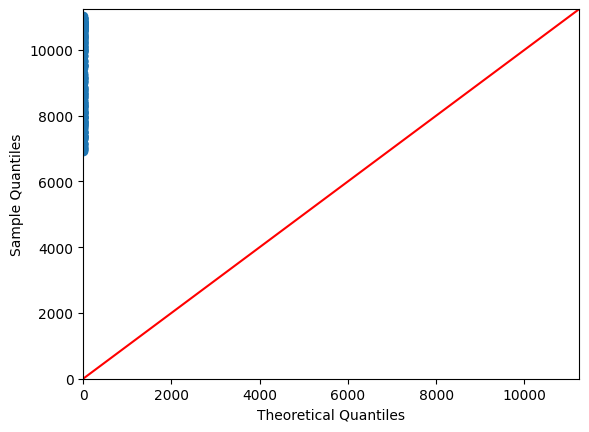

In [60]:
sm.qqplot(data['Ocupados'], line ='45')
py.show()

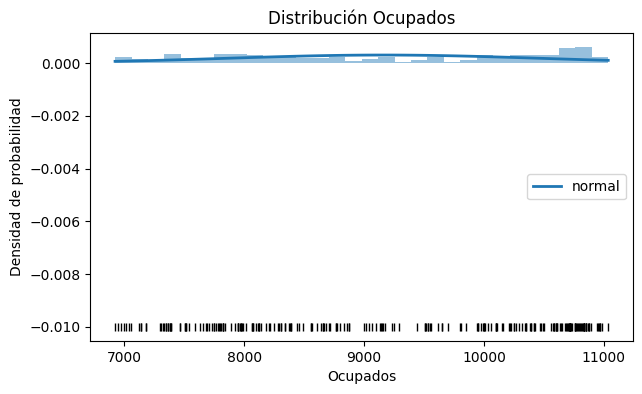

In [61]:
# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(data['Ocupados'])

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(data['Ocupados']), max(data['Ocupados']), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=data['Ocupados'], density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(data['Ocupados'], np.full_like(data['Ocupados'], -0.01), '|k', markeredgewidth=1)
ax.set_title('Distribución Ocupados')
ax.set_xlabel('Ocupados')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

In [62]:
stats.shapiro(data['Ocupados'])

ShapiroResult(statistic=np.float64(0.9111439682568433), pvalue=np.float64(3.039085379954234e-10))

In [63]:
stats.jarque_bera(data['Ocupados'])

SignificanceResult(statistic=np.float64(20.11813814008792), pvalue=np.float64(4.2795865091983345e-05))

**Nota:**

Para ambas pruebas, el p-valor es menor a 0.05, por lo que, se rechaza la hipótesis nula de que los datos provienen de una distribución normal. Es decir, no presenta comportamiento de ruido blanco gaussiano.

# **7. Pronósticos con all data**